In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tqdm import tqdm
import pandas as pd
from collections import Counter

In [2]:
DATA_DIR = '/home/zzhang14/twitter/code/travel/data'
files = os.listdir(DATA_DIR)

中央公园: a， b,c,d : 4
纽约现代艺术博物馆: a, c,e ,f,p : 5
中央公园   & 纽约现代艺术博物馆 : 2
pmi = 0.5


(1) location (经纬度) -> distance
(2) review number
(3) transportation
(4) ticket price
(5) average score

cluster

(*) sentimental analysis 
user review -> sentimental score
user -> (a) +  (b) -

15 nodes 
pmi < 0.1 -> no edge
=> graph
node attributes


In [3]:
df_list = {}
for file in files:
    df_list[file.split('.')[0]] = pd.read_excel(os.path.join(DATA_DIR, file))

In [4]:
from collections import Counter
attractions = list(df_list.keys())
counter_list = {} # record number of reviews for each user each attraction
total_counter = Counter() # record number of total users
for key in attractions:
    counter_list[key] = Counter()
    for item in df_list[key]['userName'].values.tolist():
        counter_list[key][item] += 1
        total_counter[item] += 1
        
total_num = len(total_counter) # total number of users

In [5]:
co_occurance_list = []
for key1 in attractions:
    co_occurance_list_item = []
    for key2 in attractions:
        num = 0
        for name in counter_list[key1].keys():
            if name in counter_list[key2].keys():
                num += 1
        co_occurance_list_item.append(num)
    co_occurance_list.append(co_occurance_list_item)
co_occurance_matrix = np.array(co_occurance_list)

In [6]:
pmi_list = []
for key1, i in zip(attractions, range(len(attractions))):
    pmi_list_item = []
    for key2, j in zip(attractions, range(len(attractions))):
        prob1 = len(counter_list[key1]) / total_num # p(1)
        prob2 = len(counter_list[key2]) / total_num # p(2)
        prob_12 = co_occurance_matrix[i,j] / total_num # p(1,2)
        if key1 == key2:
            calculated_pmi = 0 # do not calculate for self loop
        else:
            #calculated_pmi = (prob_12/min(prob1,prob2)) # a simpler score
            calculated_pmi = np.log10(prob_12/(prob1*prob2)) # calculate pmi score
        pmi_list_item.append(calculated_pmi)
        
    pmi_list.append(pmi_list_item)
pmi_matrix = np.array(pmi_list)

American Museum of Natural History 533
Liberty Island 1642
Empire State Building 1587
Rockefeller Plaza 512
Madame Tussauds New York 156
Times Square 1298
Hudson Street 123
Ground Zero 234
Brooklyn Bridg 384
Broadway 236
Wall Street 703
Metropolitan Museum of Art 1463
New York Museum of Modern Art 303
Solomon Guggenheim 154
Central Park 950
5th Ave 377


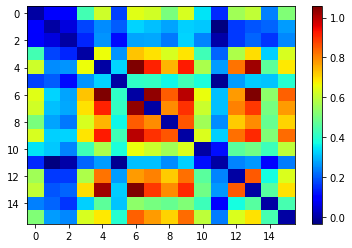

In [7]:
for key1, i in zip(attractions, range(len(attractions))):
    print(key1, len(counter_list[key1]))
plt.imshow(pmi_matrix,cmap='jet', aspect='auto')
plt.colorbar()

In [17]:
import networkx as nx
G = nx.Graph()
threshold = 0.3
for i in range(len(attractions)):
    G.add_nodes_from([(i, {"name": attractions[i]})])
for i in range(len(attractions)):
    for j in range(len(attractions)):
        if pmi_matrix[i][j] >= threshold:
            G.add_edges_from([(i, j, {'weight': pmi_matrix[i][j]})])

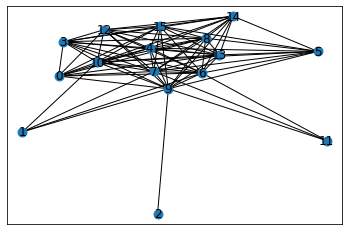

In [18]:
nx.draw_networkx(G, node_size=80) # redraw this graph in powerpoint

# first, let us do clustering analysis
In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. 

In [69]:
from networkx.algorithms.cluster import clustering
print(nx.clustering(G)) 
# this is the clustering coefficient for each node, just simply show a table. No need to explain since 
# there is no explicit clustering subgraph shown in this structure

{0: 1.0, 1: 1.0, 2: 0, 3: 0.9818181818181818, 4: 0.9393939393939394, 5: 1.0, 6: 0.7362637362637363, 7: 0.7362637362637363, 8: 0.9393939393939394, 9: 0.638095238095238, 10: 0.8333333333333334, 11: 1.0, 12: 0.9818181818181818, 13: 0.9393939393939394, 14: 0.9636363636363636, 15: 0.9393939393939394}


In [10]:
# node attribute
node_attribute_df = pd.read_excel('attribute.xlsx')

# check correlation between pmi and distance

In [23]:
dist_list, pmi_list = [], []
for i in range(len(attractions)):
    for j in range(len(attractions)):
        if i > j:
            key1, key2 = attractions[i], attractions[j]
            X1 = node_attribute_df.loc[node_attribute_df['attraction']==key1, 'X'].values[0]
            Y1 = node_attribute_df.loc[node_attribute_df['attraction']==key1, 'Y'].values[0]
            X2 = node_attribute_df.loc[node_attribute_df['attraction']==key2, 'X'].values[0]
            Y2 = node_attribute_df.loc[node_attribute_df['attraction']==key2, 'Y'].values[0]
            dist = np.sqrt((X1-X2)**2+(Y1-Y2)**2)
            dist_list.append(dist)
            pmi_list.append(pmi_matrix[i][j])
        

-0.17264872736092043

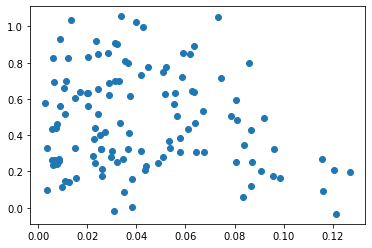

In [25]:
plt.scatter(dist_list, pmi_list)
np.corrcoef(dist_list, pmi_list)[0,1] # conclusion: the longer the distance, the lower co-occurence

# now check relationship with transportation
suppose the transportation between two attractions as (# of attr_1 + # of attr_2)

In [33]:
trans_list, pmi_list = [], []
for i in range(len(attractions)):
    for j in range(len(attractions)):
        if i > j:
            key1, key2 = attractions[i], attractions[j]
            tran_1 = node_attribute_df.loc[node_attribute_df['attraction']==key1, 'transportation'].values[0]
            tran_2 = node_attribute_df.loc[node_attribute_df['attraction']==key2, 'transportation'].values[0]
            tran = tran_1 + tran_2
            trans_list.append(tran)
            pmi_list.append(pmi_matrix[i][j])
        

0.3117038873772357

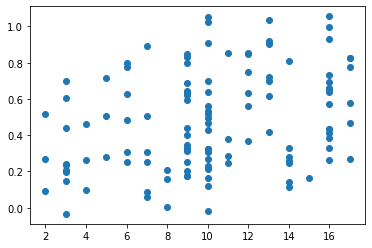

In [34]:
plt.scatter(trans_list, pmi_list)
np.corrcoef(trans_list, pmi_list)[0,1] # conclusion: the more of transportation, the higher co-occurence

# now check relationship between ticket price and review number

In [37]:
node_attribute_df[['ticket price','average score','review number']].corr()
# conclusion: the more number of reviews, the higher score
# no explicit relationship between ticket price and other two scores

,ticket price,average score,review number
ticket price,1.000000,0.093114,0.065890
average score,0.093114,1.000000,0.602013
review number,0.065890,0.602013,1.000000


# now lets change ticket price into two categories: free and no free
# see if people go to free attractions will also go to other free attraction

In [39]:
node_attribute_df['free'] = node_attribute_df['ticket price'].apply(lambda x: x > 1e-12)

In [64]:
fee_list, pmi_list = [], []
for i in range(len(attractions)):
    for j in range(len(attractions)):
        if i > j:
            key1, key2 = attractions[i], attractions[j]
            fee_1 = node_attribute_df.loc[node_attribute_df['attraction']==key1, 'free'].values[0].astype(int)
            fee_2 = node_attribute_df.loc[node_attribute_df['attraction']==key2, 'free'].values[0].astype(int)
            fee = fee_1 + fee_2
            fee_list.append(fee)
            pmi_list.append(pmi_matrix[i][j])
            
fee_list, pmi_list= np.array(fee_list), np.array(pmi_list)

In [57]:
# here x=0 represents two attractions are both free, x=1 represents one free one not, x=2 represents two attractions are both not free
# conclusion: free attractions are highly correlated since the average pmi score is siginificantly higher than other pairs

average score of pmi for three categories:
0.5838893072333472 0.48053350765831865 0.40609950327951644
standard deviation score of pmi for three categories:
0.1931834812192722 0.26192856568507944 0.29312723377846184


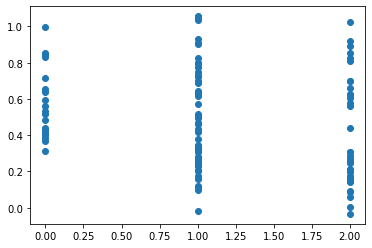

In [68]:
plt.scatter(fee_list, pmi_list)
print( 'average score of pmi for three categories:')
print( pmi_list[fee_list == 0].mean(), pmi_list[fee_list == 1].mean(), pmi_list[fee_list == 2].mean())
print( 'standard deviation score of pmi for three categories:')
print( pmi_list[fee_list == 0].std(), pmi_list[fee_list == 1].std(), pmi_list[fee_list == 2].std())